In [115]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [116]:
data = pd.read_csv('../data/chap07/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [117]:
data['Date'] = pd.to_datetime(data['Date'])  # 기존 object data type을 datetime 자료형으로 변환
data.set_index('Date', inplace=True)  # Date column을 Index로 사용할게
data['Volume'] = data['Volume'].astype(float)  # 데이터 형식을 변경할 때는 astype() 사용

In [118]:
# iloc: integer location.
# select rows and columns from a DataFrame by their numerical position (integer index), starting from 0.
X = data.iloc[:, :-1]  # 학습 데이터
y = data.iloc[:, 5:6]  # X에 대한 정답(label)
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [119]:
# rescales the data to a fixed range, 주로 [0, 1]
ms = MinMaxScaler()  #  주로 output variable(label)에 잘 쓰인다 b/c [0, 1] range stabilize the training process

# Mean: 0, standard deviation: 1
ss = StandardScaler()  # 각 attribute들의 값들의 scale, unit들이 다르니까 이를 통일해줄 필요가 있어

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]  # 200번째 까지는 트레이닝
X_test = X_ss[200:, :]  # 200 이후 떨거지는 테스트 용도로

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [120]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

# tensor shape을 (200, 1, 5)로 바꿀께 b/c LSTM 네트워크 입력 형태와 맞춰
# 2번째 파라미터의 1은 nn.lstm의 seq_length인데, time-series에서 seq_length가 1? 이럴꺼면 왜 쓰냐??
# batch_first: true인 경우 (batch, seq, feature) 순으로 들어감. 근거 rnn.py line 519
X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [121]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers
        self.input_size = input_size  # literally input_size, 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수 i.e. size of the memory vector for the LSTM
        self.seq_length = seq_length  # 어차피 forward()의 parameter로 들어가는건데 왜 멤버 변수로 박음? useless shit

        # input_size: The number of expected features in the input `x`
        # hidden_size: The number of features in the hidden state `h`
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # pytorch에서 제공하는 LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # batch_first=True니 x.size(0)이 batch size 임이 유력
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [122]:
num_epochs = 8000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [123]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.14512
Epoch: 100, loss: 0.05941
Epoch: 200, loss: 0.04625
Epoch: 300, loss: 0.04265
Epoch: 400, loss: 0.04004
Epoch: 500, loss: 0.03784
Epoch: 600, loss: 0.03522
Epoch: 700, loss: 0.03257
Epoch: 800, loss: 0.02937
Epoch: 900, loss: 0.02640
Epoch: 1000, loss: 0.02397
Epoch: 1100, loss: 0.02231
Epoch: 1200, loss: 0.02131
Epoch: 1300, loss: 0.02044
Epoch: 1400, loss: 0.01983
Epoch: 1500, loss: 0.01940
Epoch: 1600, loss: 0.01908
Epoch: 1700, loss: 0.01883
Epoch: 1800, loss: 0.01869
Epoch: 1900, loss: 0.01858
Epoch: 2000, loss: 0.01850
Epoch: 2100, loss: 0.01843
Epoch: 2200, loss: 0.01836
Epoch: 2300, loss: 0.01830
Epoch: 2400, loss: 0.01824
Epoch: 2500, loss: 0.01817
Epoch: 2600, loss: 0.01811
Epoch: 2700, loss: 0.01805
Epoch: 2800, loss: 0.01798
Epoch: 2900, loss: 0.01792
Epoch: 3000, loss: 0.01786
Epoch: 3100, loss: 0.01779
Epoch: 3200, loss: 0.01773
Epoch: 3300, loss: 0.01765
Epoch: 3400, loss: 0.01758
Epoch: 3500, loss: 0.01750
Epoch: 3600, loss: 0.01743
Epoch: 3700, 

In [124]:
df_x_ss = ss.transform(data.iloc[:, :-1])  # 데이터 정규화(분포 조정)
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

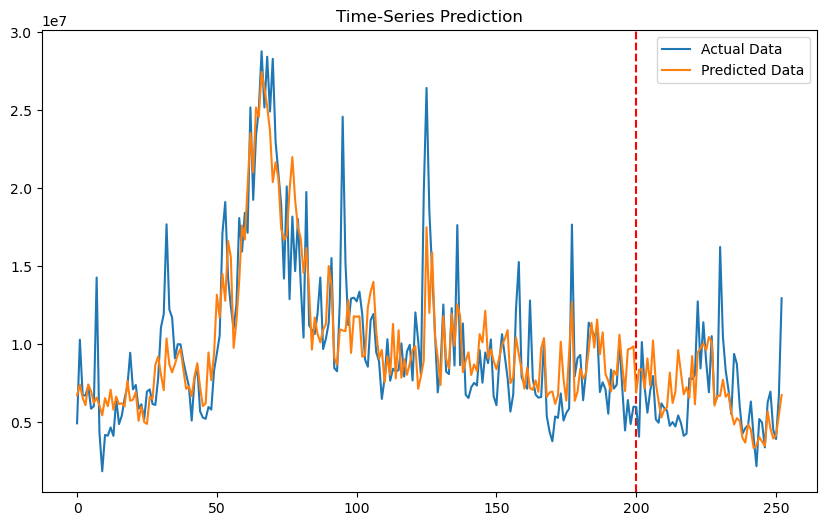

In [125]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()  # numpy array로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)  # 정규화 했던거 풀기
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

Using device: cpu
Original data shapes: (253, 5) (253, 1)
Sequence data shapes: (238, 15, 5) (238, 1)
Training Shape (200, 15, 5) (200, 1)
Testing Shape (38, 15, 5) (38, 1)
Epoch: 0, loss: 0.13742
Epoch: 100, loss: 0.01650
Epoch: 200, loss: 0.00998
Epoch: 300, loss: 0.00670
Epoch: 400, loss: 0.00505
Epoch: 500, loss: 0.00387
Epoch: 600, loss: 0.00318
Epoch: 700, loss: 0.00259
Epoch: 800, loss: 0.00227
Epoch: 900, loss: 0.00199
Epoch: 1000, loss: 0.00165
Epoch: 1100, loss: 0.00166
Epoch: 1200, loss: 0.00137
Epoch: 1300, loss: 0.00116
Epoch: 1400, loss: 0.00116
Epoch: 1500, loss: 0.00086
Epoch: 1600, loss: 0.00075
Epoch: 1700, loss: 0.00070
Epoch: 1800, loss: 0.00073
Epoch: 1900, loss: 0.00060
Epoch: 2000, loss: 0.00055
Epoch: 2100, loss: 0.00059
Epoch: 2200, loss: 0.00048
Epoch: 2300, loss: 0.00085
Epoch: 2400, loss: 0.00040
Epoch: 2500, loss: 0.00036
Epoch: 2600, loss: 0.00034
Epoch: 2700, loss: 0.00056
Epoch: 2800, loss: 0.00027
Epoch: 2900, loss: 0.00024
Epoch: 3000, loss: 0.00021
Ep

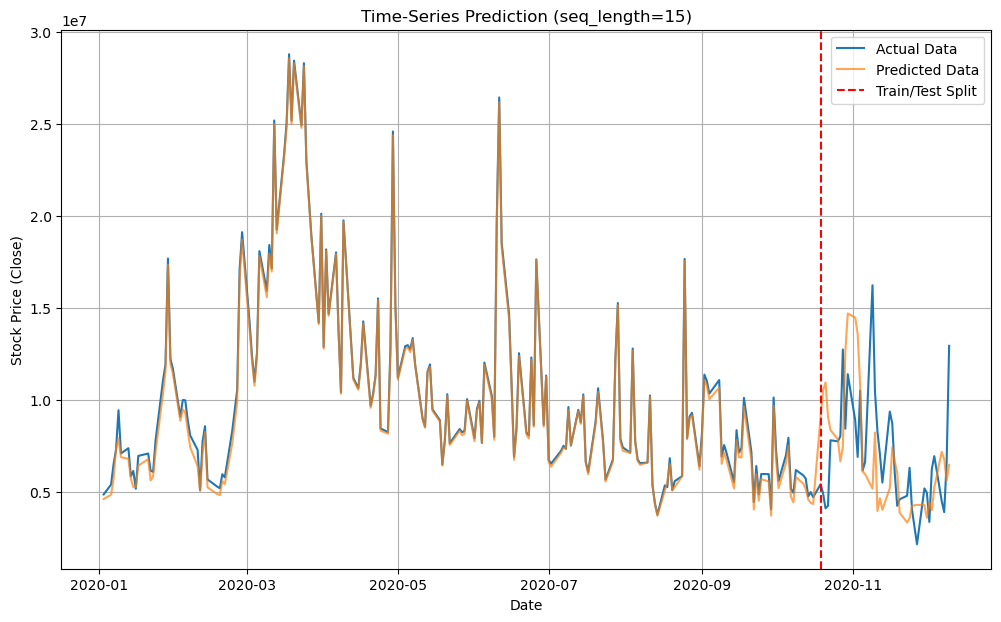

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# %% 1. Load and Preprocess Data
data = pd.read_csv('../data/chap07/SBUX.csv')

# Convert Date column and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

# Separate features (X) and target (y)
X = data.iloc[:, :-1].values # Using .values to get numpy array
y = data.iloc[:, 5:6].values # Using .values to get numpy array

# Scale the data
ss = StandardScaler()
ms = MinMaxScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

# %% 2. Create Time-Series Sequences
# This is the key part to change for a real time-series model.
# We will use data from the past 'seq_length' days to predict the next day.

def create_sequences(input_data, target_data, sequence_length):
    sequences = []
    labels = []
    # The loop runs up to the point where a full sequence can be formed
    for i in range(len(input_data) - sequence_length):
        # Grab a sequence of 'sequence_length' from the input data
        seq = input_data[i:i + sequence_length]
        # The label is the target value at the end of the sequence
        label = target_data[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the sequence length
SEQ_LENGTH = 15

# Create sequences from the scaled data
X_seq, y_seq = create_sequences(X_ss, y_ms, SEQ_LENGTH)

print("Original data shapes:", X_ss.shape, y_ms.shape)
print("Sequence data shapes:", X_seq.shape, y_seq.shape)

# %% 3. Split Data into Training and Testing Sets
# We split the generated sequences, not the original data
train_size = 200
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

# Convert to PyTorch Tensors
# The data is already in the correct (batch, seq, feature) shape
X_train_tensors = torch.Tensor(X_train).to(device)
y_train_tensors = torch.Tensor(y_train).to(device)

X_test_tensors = torch.Tensor(X_test).to(device)
y_test_tensors = torch.Tensor(y_test).to(device)

# %% 4. Define the LSTM Model
class LSTM(nn.Module):
    # Removed the useless 'seq_length' from __init__
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Initialize hidden and cell states
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Propagate input through LSTM
        # output contains all the hidden states of the sequence
        # hn is the final hidden state
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # We only need the last hidden state to make the prediction
        hn_last_layer = hn.view(-1, self.hidden_size)
        out = self.relu(hn_last_layer)
        out = self.fc_1(out)
        out = self.relu(out)
        # out = self.dropout(out)
        out = self.fc(out)
        return out

# %% 5. Train the Model
num_epochs = 8000
learning_rate = 0.001 # Slightly increased learning rate

input_size = 5      # Number of features
hidden_size = 32    # More neurons in the hidden layer can be helpful
num_layers = 1      # Number of LSTM layers
num_classes = 1     # We are predicting one value

model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():1.5f}")

# %% 6. Plot Predictions
model.eval() # Set model to evaluation mode

# Use the full sequence dataset for prediction
train_predict = model(torch.Tensor(X_seq).to(device))

# Move data to CPU and convert to numpy for plotting
predicted_data = train_predict.cpu().data.numpy()
# label_data is y_seq which is already a numpy array
label_data = y_seq

# Inverse transform to get actual stock prices
predicted = ms.inverse_transform(predicted_data)
label_y = ms.inverse_transform(label_data)

# Create an empty array to hold predictions, shifted by SEQ_LENGTH
# This helps in aligning the plot correctly
train_predict_plot = np.empty(shape=(len(data), 1))
train_predict_plot[:, :] = np.nan
train_predict_plot[SEQ_LENGTH:len(predicted) + SEQ_LENGTH, :] = predicted

# Plotting
plt.figure(figsize=(12, 7))
# THE FIX IS HERE: Slice the index to match the shortened label_y data
plt.plot(data.index[SEQ_LENGTH:], label_y, label='Actual Data')
plt.plot(data.index, train_predict_plot, label='Predicted Data', alpha=0.7)
plt.axvline(x=data.index[train_size + SEQ_LENGTH], c='r', linestyle='--', label='Train/Test Split')
plt.title(f'Time-Series Prediction (seq_length={SEQ_LENGTH})')
plt.xlabel('Date')
plt.ylabel('Stock Price (Close)')
plt.legend()
plt.grid(True)
plt.show()